<a href="https://www.kaggle.com/code/imenbakir/part-ii-amazon-products-recommender-system?scriptVersionId=131032869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="padding:10px;background-color:#FF9900;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Amazon products Recommendation System</p>

![im1](https://cdn.activestate.com/wp-content/uploads/2019/12/RecommendationEngine.png)

## Importing Libraries

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Input

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer,TFBertForSequenceClassification
%matplotlib inline

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:130%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Table Of Contents</p>   
    

    
|No  | Contents 
|:---| :---     
|1   | [<font color="#0f4c5c"> Sentiment Analysis </font>](#1)                  
|2   | [<font color="#0f4c5c">  Feature Extraction</font>](#2)                                  
|3   | [<font color="#0f4c5c">  Recommender System using transfer learning </font>](#3)                       
|4   | [<font color="#0f4c5c"> Recommender System using other models </font>](#5)        

<a id='1'></a>
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:170%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Sentiment Analysis</p>

In the previous [notebook](https://www.kaggle.com/code/imenbakir/nlp-amazon-products-recommender-system#Text-Pre-processing) I've conducted Text Pre-processing with techniques such as Removing punctuation, Converting text to lowercase, Tokenization, Lemmatization etc... and applied VADER to the dataset to categorize sentiment labels based on sentiment scores.

In this notebook I'm going to have a more in-depth application of **Rule-based Sentiment Analysis** with VADER on the clean dataset to analyze sentiments and categorize them into positive, neutral or negative.

I decided to take only reviews on software products from the original dataset

#### What is VADER ?

**VADER, or Valence Aware Dictionary and sEntiment :** is one of the most popular rule-based sentiment analysis methods, adjusted to the sentiments expressed on social media.


It performs better on content that you can discover on social media because it is tuned for social media content. As you can see in the example below, it still produces respectable F1 Scores on other test sets and performs similarly to more intricate statistical models like Support Vector Machines.

![img](https://miro.medium.com/v2/resize:fit:720/format:webp/1*cM3dLKxyh74V58Ay_HkTQg.png)

-Three-class Accuracy (F1 scores) for Each Machine Trained Model (Figure from the paper)
[1](https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-rule-based-vader-and-nltk-72067970fb71)

#### What is the purpose of VADER ?


To perform sentiment analysis on textual data, VADER can be applied for the purpose of assessing sentiments in social media messages, online reviews, and other brief and informal writings, it is a lexicon- and rule-based sentiment analysis tool.

The main goals of using VADER in sentiment analysis :

- Fine-grained sentiment analysis: It provides sentiment intensity scores for both positive and negative sentiments, allowing for a more nuanced understanding of sentiment polarity. It is meant to identify a target (topic) of a sentiment : A sentence is broken into phrases or clauses, and each part is analyzed in a connection with others.

- Handling of contextual cues: It takes into account factors like negation, emphasis, and punctuation to accurately assess the sentiment expressed in a piece of text.

- Domain adaptation: VADER's lexicon includes sentiment scores for a vast number of words, including slang, emoticons, and internet-specific jargon. This lexicon can be adapted or expanded to suit specific domains or contexts, making it flexible for sentiment analysis tasks across various domains.

- Fast and efficient analysis: VADER employs a rule-based approach, which makes it computationally efficient and suitable for real-time or large-scale sentiment analysis tasks.

#### Loading the dataset:

In [19]:
software_df = pd.read_csv('/kaggle/input/filtered-dataset/filtered_dataset.csv')

In [20]:
software_df.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_score,sentiment_label
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,0.34,positive


#### Assigning sentiment labels automatically without the help of VADER

In [21]:
columns = ['sentiment_score', 'sentiment_label']
software_df1 = software_df.drop(columns= columns , axis=1)

In [22]:
software_df1.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software


In [23]:
def assign_sentiment_label(score):
    """
     function to assign sentiment labels based on overall scores
    """
    
    if score >= 4:
        return 'positive'
    elif score < 3:
        return 'negative'
    else:
        return 'neutral'

#applying the function to create the sentiment_label column
software_df1['sentiment_label'] = software_df1['overall'].apply(assign_sentiment_label)

software_df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_label
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,positive
1,4,True,2014-02-23,A1YCCU0YRLS0FE,0077613252,Rosalind White Ames,really enjoying book worksheet make review goa...,health,software,positive
2,1,True,2014-02-17,A1BJHRQDYVAY2J,0077613252,Allan R. Baker,taking class do not waste money called book bo...,kiding,software,negative
3,3,True,2014-02-17,APRDVZ6QBIQXT,0077613252,Lucy,book missing page important page could not ans...,missing page,software,neutral
4,5,False,2013-10-14,A2JZTTBSLS1QXV,0077775473,Albert V.,used learnsmart officially say amazing study t...,best study product,software,positive


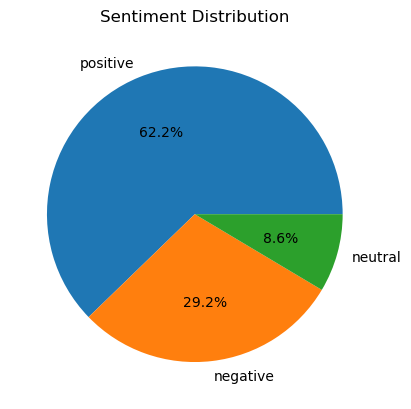

In [24]:
#count the number of reviews for each sentiment label
sentiment_counts1 = software_df1['sentiment_label'].value_counts()

plt.pie(sentiment_counts1, labels=sentiment_counts1.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show();

#### VADER

In [25]:
# Loading VADER Sentiment Intensity Analyzer
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**For testing purposes, let’s feed it a simple sentence with neutral and negative words**

In [26]:
sentences = ['Hello, world. I suck']
for word in sentences:
    print(word)
    ss = sia.polarity_scores(word)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')

Hello, world. I suck
compound: -0.4404, neg: 0.592, neu: 0.408, pos: 0.0, 

This model gave four scores: (1) Negativity, (2) Positivity, (3) Neutrality score of the sentence, and finally, (4) Compound sentiment score of the sentence. 

The compound score is basically an aggregated version of the first three scores, and we will be using this score to measure the sentiment of our reviews.

##### Calculating Polarity Scores and Predicting:

We were able to determine the sentiment score for a single sentence, now we need to execute a loop for the entire dataset.

We can shuffle the dataset before computing the scores : 

In [27]:
columns = ['sentiment_score', 'sentiment_label']
software_df2 = software_df.drop(columns= columns , axis=1)

In [28]:
# Shuffle data (Not really necessary, just for good practice)
software_slice = software_df2.sample(frac=1.0).reset_index(drop=True)

In [29]:
software_slice.head(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category
0,2,True,2017-02-25,A3T5EO58NC27YL,B01326J80Q,Amazon Customer,flexible wish would bring back microsoft money,two star,software
1,4,True,2018-03-19,A22BZNSD818MVG,B0050JCW1Q,Jean Colby,work good need do not need,four star,software
2,1,True,2015-01-09,A1PS4I99VSR6OD,B00HRQB216,OSFarmDoc,amazon give star review long time movie studio...,really zero star,software
3,5,False,2015-12-28,AY8Y7IIPNA3QA,B010P91LYY,Jeremy A.,work great intended,work great intended,software
4,4,False,2013-03-04,A157JQX1UOIZ26,B008H3SW4I,M. Liniarski,let face tablet smartphones taking computing m...,microsoft tackle mobile world,software


##### Apply a lambda function on our dataset column reviewText and create a new column to save the results with the name sentiment_label :

First, I have encountered an error and it's due to the presence of null values in the 'reviewText' column (that was unexpected because I have already applied data pre processing in the previous notebook)

In [30]:
software_slice.isnull().sum()

overall            0
verified           0
reviewTime         0
reviewerID         0
asin               0
reviewerName       0
reviewText       555
summary         1192
category           0
dtype: int64

In [31]:
software_slice.duplicated().value_counts()

False    450856
True         13
dtype: int64

In [32]:
software_slice.drop_duplicates(inplace=True)

In [33]:
software_slice.duplicated().value_counts()

False    450856
dtype: int64

In [34]:
#replace NaN values with 'Unknown'
software_slice['reviewText'].fillna('Unknown', inplace=True)

In [35]:
software_slice['summary'].fillna('Unknown', inplace=True)

In [36]:
def analyze_sentiment(text):
    """
    Function to analyze the sentiment of a given text using VADER sentiment analyzer
    """
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

def categorize_sentiment(score):
    """
    Function to categorize the sentiment score into sentiment labels
    """
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

In [37]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 17.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16322 sha256=fbaddb643e4b8c25ce2b2fc9db0ee834a71bf6b6c836627d8f11923d844a20d2
  Stored in directory: /root/.cache/pip/wheels/6c/bd/3e/2d6afc9bc36c9975f8e4215a270bbac6580c4361ebd6bb2323
Successfully built swifter


In [38]:
import swifter

# Perform sentiment analysis on review text to generate sentiment scores
software_slice['sentiment_score'] = software_slice['reviewText'].swifter.apply(analyze_sentiment)

# Categorize sentiment scores into labels (e.g., positive, negative, neutral)
software_slice['sentiment_label'] = software_slice['sentiment_score'].swifter.apply(categorize_sentiment)

Pandas Apply:   0%|          | 0/450856 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/450856 [00:00<?, ?it/s]

In [39]:
software_slice.head(1)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_score,sentiment_label
0,2,True,2017-02-25,A3T5EO58NC27YL,B01326J80Q,Amazon Customer,flexible wish would bring back microsoft money,two star,software,0.5574,positive


In [40]:
software_slice.sentiment_score.describe()

count    450856.000000
mean          0.435670
std           0.499831
min          -0.997200
25%           0.036100
50%           0.612400
75%           0.848100
max           0.999900
Name: sentiment_score, dtype: float64

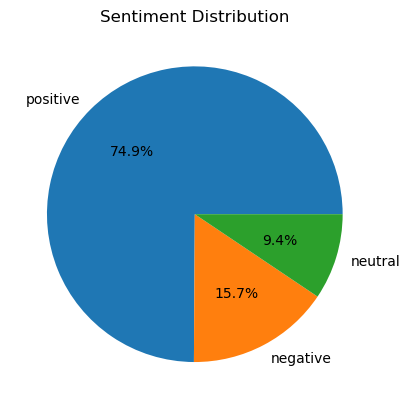

In [41]:
#count the number of reviews for each sentiment label
sentiment_counts = software_slice['sentiment_label'].value_counts()

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show();

##### Create a Confusion Matrix

Finally, I want to create a confusion matrix to properly measure our rule-based NLP sentiment classifier's success. 

A confusion matrix shows True Positives, True Negatives, False Positives, and False Negatives, which we can use to calculate Accuracy, Recall, Precision, and F1 Scores. 

With the lines below, I will create a custom function to generate confusion matrix tags and apply them as a lambda function

In [42]:
merged_df = pd.concat([software_df1['sentiment_label'], software_slice['sentiment_label']], axis=1, ignore_index=True, keys=['actual', 'predicted'])

In [43]:
merged_df.columns = ['actual_sentiment', 'predicted_sentiment']

In [44]:
merged_df.head()

,actual_sentiment,predicted_sentiment
0,positive,positive
1,positive,positive
2,negative,positive
3,neutral,positive
4,positive,positive


In [45]:
def conf_matrix(row):
    if row['actual_sentiment'] == 'positive' and row['predicted_sentiment'] == 'positive':
        return 'TP'
    elif row['actual_sentiment'] == 'positive' and row['predicted_sentiment'] == 'negative':
        return 'FN'
    elif row['actual_sentiment'] == 'negative' and row['predicted_sentiment'] == 'positive':
        return 'FP'
    elif row['actual_sentiment'] == 'negative' and row['predicted_sentiment'] == 'negative':
        return 'TN'
    else:
        return 0

# Create the 'Conf_Matrix' column using the conf_matrix function
merged_df['Conf_Matrix'] = merged_df.apply(conf_matrix, axis=1)

In [46]:
merged_df.head()

,actual_sentiment,predicted_sentiment,Conf_Matrix
0,positive,positive,TP
1,positive,positive,TP
2,negative,positive,FP
3,neutral,positive,0
4,positive,positive,TP


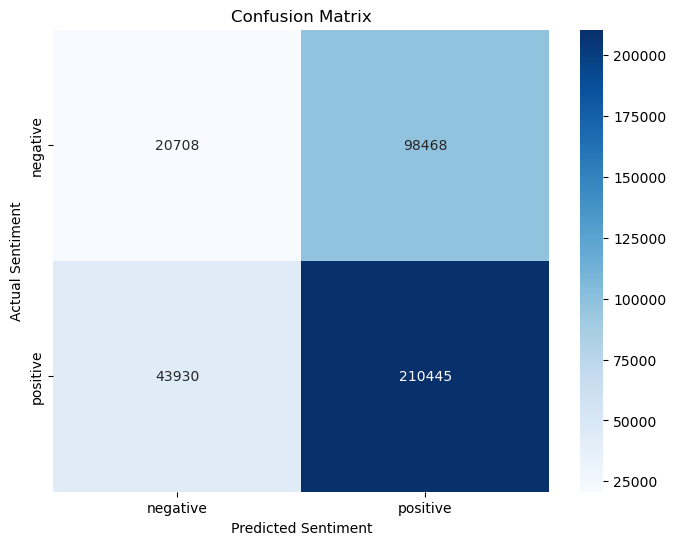

In [47]:
import seaborn as sns


# Filter out the rows with neutral labels
merged_df = merged_df[merged_df['Conf_Matrix'] != 0]

#a pivot table to get the counts
cm = pd.pivot_table(merged_df, index='actual_sentiment', columns='predicted_sentiment',
                                  values='Conf_Matrix', aggfunc='count', fill_value=0)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()

##### Calculating Accuracy, Recall, Precision, and F1 Score:

To see how we did with our VADER model, I will use several custom formulas to calculate Accuracy, Recall, Precision, and F1 Score.

In [48]:
merged_df.head()

,actual_sentiment,predicted_sentiment,Conf_Matrix
0,positive,positive,TP
1,positive,positive,TP
2,negative,positive,FP
4,positive,positive,TP
5,positive,positive,TP


In [49]:
conf_vals = merged_df.Conf_Matrix.value_counts().to_dict()
print(conf_vals)

{'TP': 210445, 'FP': 98468, 'FN': 43930, 'TN': 20708}


In [50]:
accuracy = (conf_vals['TP'] + conf_vals['TN']) / (conf_vals['TP'] + conf_vals['TN'] + conf_vals['FP'] + conf_vals['FN'])
precision = conf_vals['TP'] / (conf_vals['TP'] + conf_vals['FP'])
recall = conf_vals['TP'] / (conf_vals['TP'] + conf_vals['FN'])
f1_score = 2*precision*recall / (precision + recall)


print('Accuracy: ', round(100 * accuracy, 2),'%',
      '\nPrecision: ', round(100 * precision, 2),'%',
      '\nRecall: ', round(100 * recall, 2),'%',
      '\nF1 Score: ', round(100 * f1_score, 2),'%')

Accuracy:  61.88 % 
Precision:  68.12 % 
Recall:  82.73 % 
F1 Score:  74.72 %


VADER achieved a 61% accuracy on the amazon software products reviews. 

Don’t forget that VADER is a social-media lexicon. Therefore, using a software-reviews-based Lexicon would give us even higher performances.

<a id='2'></a>
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:170%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Feature Extraction</p>

In the context of sentiment analysis and building a recommender system based on user reviews, feature extraction refers to the process of **transforming textual data** (user reviews) into a **numerical representation** that can be used as **input** for **machine learning algorithms**.

Feature extraction involves selecting or extracting relevant information from the raw text that can capture the sentiment or characteristics of the reviews. 
The extracted features are then used to train models for sentiment analysis or to build recommendation systems.

There are several feature extraction techniques that can be used, some commonly used techniques include:

1. **Bag-of-Words (BoW):** It represents text as a collection of unique words, disregarding grammar and word order. Each word becomes a feature, and the frequency or presence of words in a document is used for analysis.

2. **Term Frequency-Inverse Document Frequency (TF-IDF):** It measures the importance of a word in a document by considering its frequency in the document and across the entire corpus. It assigns higher weights to rare words that are more informative.

3. **Word Embeddings:** such as Word2Vec or GloVe, capture the semantic meaning of words by representing them as dense vectors in a continuous space. These embeddings can be used as features to capture the contextual information and relationships between words.

4. **N-grams:** N-grams represent contiguous sequences of n words. They capture local word order and can provide more contextual information compared to BoW.

5. **Topic Modeling:** Techniques like Latent Dirichlet Allocation (LDA) can identify latent topics in a corpus. Topics can serve as features that capture the underlying themes in user reviews.

In [51]:
software_df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_label
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,positive
1,4,True,2014-02-23,A1YCCU0YRLS0FE,0077613252,Rosalind White Ames,really enjoying book worksheet make review goa...,health,software,positive
2,1,True,2014-02-17,A1BJHRQDYVAY2J,0077613252,Allan R. Baker,taking class do not waste money called book bo...,kiding,software,negative
3,3,True,2014-02-17,APRDVZ6QBIQXT,0077613252,Lucy,book missing page important page could not ans...,missing page,software,neutral
4,5,False,2013-10-14,A2JZTTBSLS1QXV,0077775473,Albert V.,used learnsmart officially say amazing study t...,best study product,software,positive


<a id='3'></a>
<p style="padding:10px;background-color:#0f4c5c;margin:0;color:white;font-family:newtimeroman;font-size:170%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Recommender System using transfer learning</p>

### 1. Fine Tuning BERT model

**What is BERT?**


Bidirectional Encoder Representation for Transformer (BERT) is an NLP model developed by Google Research in 2018, after its inception it has achieved state-of-the-art accuracy on several NLP tasks.

Transformer architecture has encoder and decoder stack, hence called encoder-decoder architecture whereas BERT is just an encoder stack of transformer architecture. There are two variants, BERT-base and BERT-large, which differ in architecture complexity. The base model has 12 layers in the encoder whereas the Large has 24 layers.

![bert](https://editor.analyticsvidhya.com/uploads/42979transformer_arch.png)

- Source : Transformer Architecture(https://arxiv.org/pdf/1706.03762.pdf)

![bert model](https://editor.analyticsvidhya.com/uploads/13789bert_architecture.png)

- Source: BERT Model(https://humboldtwi.github.io/blog/research/information_systems_1920/bert_blog_post/)

#### Tokenizing text

To find the maximum and average length of the text in the reviewText column.

The maximum length is important because it helps determine the input shape for the LSTM layer.

In [53]:
software_df1['reviewText'].isnull().sum()

555

In [56]:
#replace NaN values with 'Unknown'
software_df1['reviewText'].fillna('Unknown', inplace=True)
software_df1['summary'].fillna('Unknown', inplace=True)

In [57]:
software_df1['reviewText'].isnull().sum()

0

**Visualizing Text Distribution**

calculating the maximum sequence length for the text data in the 'reviewText' column

In [66]:
import numpy as np

software_df1['txt_len'] = software_df1['reviewText'].apply(lambda x: len(x.split(" ")))
max_seq_len = np.round(software_df1['txt_len'].mean() + 2 * software_df1['txt_len'].std()).astype(int)
max_seq_len

167

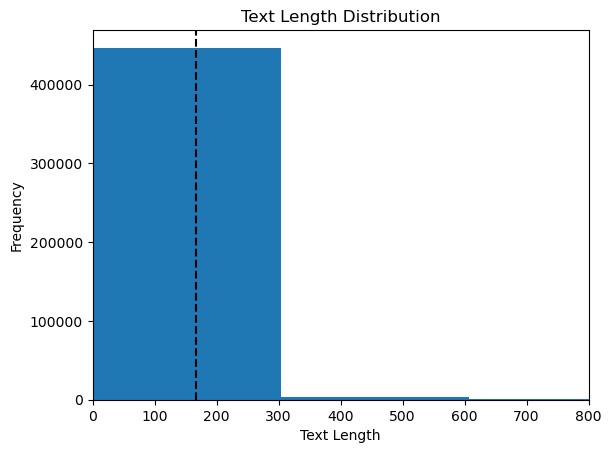

In [69]:
software_df1['txt_len'].plot.hist()
plt.xlim(0, 800)  # Set the x-axis limits
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.xlabel('Text Length')
plt.title('Text Length Distribution')
plt.show();

In [74]:
software_df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,category,sentiment_label,txt_len
0,4,True,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,material arrived early excellent condition how...,material great,software,positive,15
1,4,True,2014-02-23,A1YCCU0YRLS0FE,0077613252,Rosalind White Ames,really enjoying book worksheet make review goa...,health,software,positive,12
2,1,True,2014-02-17,A1BJHRQDYVAY2J,0077613252,Allan R. Baker,taking class do not waste money called book bo...,kiding,software,negative,28
3,3,True,2014-02-17,APRDVZ6QBIQXT,0077613252,Lucy,book missing page important page could not ans...,missing page,software,neutral,12
4,5,False,2013-10-14,A2JZTTBSLS1QXV,0077775473,Albert V.,used learnsmart officially say amazing study t...,best study product,software,positive,50


#### Split data into Train and Test sets

In [99]:
train_df, val_df = train_test_split(software_df1, test_size=0.2, random_state=42)

#### Tokenize text & padding

In [79]:
example = software_df1['reviewText'][0]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.tokenize(example)

['material',
 'arrived',
 'early',
 'excellent',
 'condition',
 'however',
 'money',
 'spent',
 'really',
 'should',
 'have',
 'come',
 'bind',
 '##er',
 'loose',
 'leaf']

In [80]:
tokenizer.encode(example)

[101,
 3430,
 3369,
 2220,
 6581,
 4650,
 2174,
 2769,
 2985,
 2428,
 2323,
 2031,
 2272,
 14187,
 2121,
 6065,
 7053,
 102]

Tokenize the text using the BERT tokenizer and convert it to input features:

The encode_plus  function of the tokenizer class will tokenize the raw input, add the special tokens, and pad the vector to a size equal to max length

#### Let’s prepare the data according to the format needed for the BERT model

**Input IDs** – The input ids are often the only required parameters to be passed to the model as input. Token indices, numerical representations of tokens building the sequences that will be used as input by the model.

**Attention mask** – Attention Mask is used to avoid performing attention on padding token indices. Mask value can be either 0 or 1, 1 for tokens that are NOT MASKED, 0 for MASKED tokens.

**Token type ids** – It is used in use cases like sequence classification or question answering. As these require two different sequences to be encoded in the same input IDs. Special tokens, such as the classifier[CLS] and separator[SEP] tokens are used to separate the sequences.

![bert input output](https://editor.analyticsvidhya.com/uploads/79452bert-text-classification-input.width-1280.png)

- Source: BERT Input/Output(https://pysnacks.com/machine-learning/bert-text-classification-with-fine-tuning/)

In [96]:
def convert_review_to_feature(review):
    return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_seq_len, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [95]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    """
    Transform raw data to an appropriate format ready to feed into the BERT model.
    """
    return {
          "input_ids": input_ids,
          "token_type_ids": token_type_ids,
          "attention_mask": attention_masks,
      }, label

In [110]:
def encode_reviews(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
        
    for review, label in zip(ds['reviewText'], ds['sentiment_label']):
        bert_input = convert_review_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [101]:
batch_size=32

**Let’s form our train and test dataset**

In [112]:
# train dataset
train_encoded = encode_reviews(train_df).shuffle(10000).batch(batch_size)
# test dataset
test_encoded = encode_reviews(val_df).batch(batch_size)

KeyboardInterrupt: 

**Model Configuration**

In [84]:
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


**Customizing the model's hyperparameters and optimizer:**

In [113]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

number_of_epochs = 50

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [83]:
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
from gensim import utils
from gensim.models.deprecated.doc2vec import LabeledSentence
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import 	re
from gensim.corpora.dictionary import Dictionary
import multiprocessing

from random import shuffle

import numpy as np


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout

np.random.seed(1500)  # For Reproducibility

import logging

ModuleNotFoundError: No module named 'gensim.models.deprecated'

In [89]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import 	re


def tokenizer(text):
    text = [clean_tweet(document) for document in text]
    return text

In [ ]:
def sentences_perm(sentences):
    shuffle(sentences)
    return sentences

In [ ]:
log = logging.getLogger()
#log.setLevel(logging.DEBUG)

ch = logging.StreamHandler(sys.stdout)
#ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
log.addHandler(ch)

vocab_dim = 118717
maxlen = 50
n_iterations = 10  # ideally more..
n_exposures = 30
window_size = 5
batch_size = 32
n_epoch = 2
input_length = 50
cpu_count = multiprocessing.cpu_count()
log.info('source load')
sources = {'negative_test.txt':'TEST_NEG', 'positive_test.txt':'TEST_POS', 'negative_train.txt':'TRAIN_NEG', 'positive_train.txt':'TRAIN_POS'}

In [ ]:
def import_tag(datasets=None):
    if datasets is not None:
        train = {}
        test = {}
        for k, v in datasets.items():
            with open(k) as fpath:
                data = fpath.readlines()
            for val, each_line in enumerate(data):
                if v.endswith("NEG") and v.startswith("TRAIN"):
                    train[val] = each_line
                elif v.endswith("POS") and v.startswith("TRAIN"):
                    train[val + 40000] = each_line
                elif v.endswith("NEG") and v.startswith("TEST"):
                    test[val] = each_line
                else:
                    test[val + 10000] = each_line
        return train, test
    else:
        print('Data not found...')

In [ ]:
def create_dictionaries(train=None,test=None,model=None):
    if (train is not None) and (model is not None) and (test is not None):
        gensim_dict = Dictionary()
        gensim_dict.doc2bow(model.vocab.keys(),
                            allow_update=True)
        w2indx = {v: k+1 for k, v in gensim_dict.items()}
        w2vec = {word: model[word] for word in w2indx.keys()}

        def parse_dataset(data):
            for key in data.keys():
                txt = data[key].lower().replace('\n', '').split()
                new_txt = []
                for word in txt:
                    try:
                        new_txt.append(w2indx[word])
                    except:
                        new_txt.append(0)
                data[key] = new_txt
            return data
        train = parse_dataset(train)
        test = parse_dataset(test)
        return w2indx, w2vec, train, test
    else:
        print('No data provided...')

In [ ]:
print('Loading Data...')
train, test = import_tag(datasets=sources)
combined = train.values() + test.values()

print('Tokenising...')
combined = tokenizer(combined)

#print combined

print('Training a Word2vec model...')
model = Word2Vec(size=maxlen,
                 window=window_size,
                 workers=cpu_count)

model.build_vocab(combined)


In [ ]:
for epoch in range(10):
	log.info('EPOCH: {}'.format(epoch))
	model.train(sentences_perm(combined))

print('Transform the Data...')
index_dict, word_vectors, train, test = create_dictionaries(train=train,
                                                            test=test,
                                                            model=model)

print('Setting up Arrays for Keras Embedding Layer...')
n_symbols = len(index_dict) + 1  # adding 1 to account for 0th index
embedding_weights = np.zeros((n_symbols, maxlen))
for word, index in index_dict.items():
    embedding_weights[index, :] = word_vectors[word]

print('Creating Datesets...')

In [ ]:
X_train = train.values()
y_train = [1 if value > 40000 else 0 for value in train.keys()]
X_test = test.values()
y_test = [1 if value > 10000 else 0 for value in test.keys()]

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Convert labels to Numpy Sets...')
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print('Defining a Simple Keras Model...')
lstm_model = Sequential()  # or Graph 
lstm_model.add(Embedding(output_dim=maxlen,
                    input_dim=n_symbols,
                    mask_zero=True,
                    weights=[embedding_weights],
                    input_length=input_length))  # Adding Input Length
lstm_model.add(LSTM(maxlen))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))

print('Compiling the Model...')
lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
	      class_mode='binary')

print("Train...")
lstm_model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=5,
          validation_data=(X_test, y_test))

print("Evaluate...")
score, acc = lstm_model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

#### 2.Term Frequency-Inverse Document Frequency (TF-IDF)

#### 3.Word2Vec with Long Short Term Memory (LSTM)